In [2]:
!source ../meta_env/bin/activate

In [1]:
!cd /projects/academic/courses/cse676smr23/asugam/meta_learning_project

In [6]:
!pip install torch torchvision matplotlib tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 619.9 MB 42 kB/s s eta 0:00:01  |                                | 102 kB 5.8 MB/s eta 0:01:48     |▎                               | 5.0 MB 5.8 MB/s eta 0:01:47     |▎                               | 5.6 MB 5.8 MB/s eta 0:01:47     |▉                               | 15.4 MB 8.4 MB/s eta 0:01:12     |█                               | 21.5 MB 10.9 MB/s eta 0:00:55     |█▍                              | 25.9 MB 10.9 MB/s eta 0:00:55     |█▉                              | 35.8 MB 8.5 MB/s eta 0:01:10     |██                              | 39.7 MB 8.5 MB/s eta 0:01:09     |██▍                             | 47.0 MB 11.6 MB/s eta 0:00:50     |██▊                             | 53.1 MB 11.6 MB/s eta 0:00:49     |███▊                            | 71.3 MB 8.4 MB/s eta 0:01:06     |███▊                            | 71.9 MB 8.4 MB/s eta 0:01:06     |███▊                            

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import LinearLR



class MyTransform:
    def __init__(self, image_size, horizontal_flip=False, rotation_angle=None):
        transform_list = [
            #transforms.RandomResizedCrop(image_size),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        if horizontal_flip:
            transform_list.append(transforms.RandomHorizontalFlip())
        if rotation_angle is not None:
            transform_list.append(transforms.RandomRotation(degrees=rotation_angle))

        self.transform = transforms.Compose(transform_list)

    def __call__(self, img):
        return self.transform(img)

# Path to the ImageNet dataset directory
#data_dir = './ImageNet'

# Parameters for image augmentation
image_size = 224
horizontal_flip = False
rotation_angle = None

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import numpy as np
import torch

# define configuration
class Config:
    def __init__(self):
        self.n_way = 3  # N-way
        self.k_spt = 5  # K-shot
        self.k_query = self.k_qry =10  # K-query
        self.img_size = (224, 224)  # size of images
        self.batch_size = 1  # batch size
        self.inner_update_lr = 0.01  # inner update learning rate
        self.meta_lr = 1e-3  # meta learning rate
        self.meta_batch_size = 10  # size of meta batch
        self.max_epoch = 10  # number of epochs
        self.num_tasks = 10  # number of tasks

config = Config()



In [4]:
import os
import random
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
'''
try:
    !rm -r /projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/meta_tasks_symlink
except:
    print("nothing to delete")
finally:
    !mkdir /projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/meta_tasks_symlink

try:
    !rm -r /projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/meta_test_tasks_symlink
except:
    print("nothing to delete")
finally:
    !mkdir /projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/meta_test_tasks_symlink
'''
class MetaLearningDataset(Dataset):
    def __init__(self, root_dir, num_tasks, num_classes, support_set_size, query_set_size,transform = None, is_test_loader=False,seed = 0):
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.support_set_size = support_set_size
        self.query_set_size = query_set_size
        self.seed = seed
        self.transform = transform
        self.is_test_loader = is_test_loader

        self.root_dir = root_dir
        if self.is_test_loader:
            self.task_dir = '/projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/meta_test_tasks_symlink'
        else:
            self.task_dir = '/projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/meta_tasks_symlink'
        self.class_names = os.listdir(self.root_dir)
        
        self.task_seeds = np.arange(seed, seed + num_tasks)
        np.random.shuffle(self.task_seeds)

        # Create task directories
        for task_seed in self.task_seeds:
            task_seed = int(task_seed)
            task_dir_path = os.path.join(self.task_dir, f'task_{task_seed}')
            if os.path.exists(task_dir_path) and os.path.isdir(task_dir_path):
                continue
            
            random.seed(task_seed)
            np.random.seed(task_seed)

            task_classes = random.sample(self.class_names, self.num_classes)
            print(f'### {task_classes}')
            # Create symbolic links to the chosen class directories in the task directory
            for class_name in task_classes:
                class_dir = os.path.join(self.root_dir, class_name)
                class_images = os.listdir(class_dir)
                task_images = random.sample(class_images, min(self.support_set_size + self.query_set_size, len(class_images)))
                for img_name in task_images:
                    src = os.path.join(class_dir, img_name)
                    dst_dir = os.path.join(self.task_dir, f'task_{task_seed}', class_name)
                    os.makedirs(dst_dir, exist_ok=True)
                    dst = os.path.join(dst_dir, img_name)
                    os.symlink(src, dst)
        print('created symlinks for each task')

    def __getitem__(self, index):
        task_seed = int(self.task_seeds[index%self.num_tasks])
        
        task_folder = os.path.join(self.task_dir, f'task_{task_seed}')
        
        # Load the task directory using ImageFolder
        
        image_dataset = ImageFolder(task_folder, transform=self.transform)

        # Randomly select the support and query set
        random.seed(task_seed)
        np.random.seed(task_seed)

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for class_idx in range(self.num_classes):
            # Get all images of this class
            class_images = [(img, target) for img, target in image_dataset if target == class_idx]
            
            # Ensure there are enough images for support and query set
            if not self.is_test_loader:
                assert len(class_images) >= self.support_set_size + self.query_set_size

            # Randomly select images for support set and query set
            indices = list(range(len(class_images)))
            random.shuffle(indices)

            # Select support_set_size images for support set
            for i in indices[:self.support_set_size]:
                img, label = class_images[i]
                support_images.append(img)
                support_labels.append(torch.tensor(class_idx))

            for i in indices[self.support_set_size:self.support_set_size + self.query_set_size]:
                img, label = class_images[i]
                query_images.append(img)
                query_labels.append(torch.tensor(class_idx))
                
        # Shuffle support set and query set
        support_set = list(zip(support_images, support_labels))
        random.shuffle(support_set)
        support_images, support_labels = zip(*support_set)

        query_set = list(zip(query_images, query_labels))
        random.shuffle(query_set)
        query_images, query_labels = zip(*query_set)

        # Convert lists of images and labels to tensors
        support_set_X_batch = torch.stack(support_images)
        support_set_y_batch = torch.stack(support_labels)
        query_set_X_batch = torch.stack(query_images)
        query_set_y_batch = torch.stack(query_labels)

        return support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch

    def __len__(self):
        return self.num_tasks


In [5]:
train_dataset_path = '/projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/train_tasks' 
test_dataset_path = '/projects/academic/courses/cse676smr23/asugam/meta_learning_project/data/big_final_category'

In [6]:

test_meta_learning_loader = MetaLearningDataset(root_dir = test_dataset_path , is_test_loader = True, num_tasks = 1, num_classes = 3, support_set_size = 5, query_set_size = 500,transform =MyTransform(image_size, horizontal_flip, rotation_angle) )


created symlinks for each task


In [7]:

meta_learning_loader = MetaLearningDataset(root_dir = train_dataset_path , num_tasks = 100, num_classes = 3, support_set_size = 5, query_set_size = 10,transform =MyTransform(image_size, horizontal_flip, rotation_angle) )


created symlinks for each task


In [18]:
val = meta_learning_loader[7]
val[1].shape

torch.Size([15])

In [15]:
import torchvision.models as models


class MyPretrainedAlexNet(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(MyPretrainedAlexNet, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)
        self.alexnet.classifier[6] = torch.nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [8]:
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from copy import deepcopy
import torchvision.models as models

class MyAlexNet(nn.Module):
    def __init__(self, num_classes=3, use_dropout=False, reg_strength = 0.2):
        super(MyAlexNet, self).__init__()

        self.reg_strength = reg_strength

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout() if use_dropout else nn.Identity(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout() if use_dropout else nn.Identity(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def l1_regularization_loss(self):
        l1_loss = torch.tensor(0.0).to(self.features[0].weight.device)
        for param in self.parameters():
            l1_loss += torch.norm(param, p=1)
        return self.reg_strength * l1_loss

    def l2_regularization_loss(self):
        l2_loss = torch.tensor(0.0).to(self.features[0].weight.device)
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)
        return self.reg_strength * l2_loss

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(MyResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [9]:
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def confusion_mat(true_labels, predicted_labels):

    cm = confusion_matrix(true_labels, predicted_labels)

    # Compute the classification accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Create a list of class labels

    # Create a heatmap of the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdGy')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


class MAMLFewShot:
    def __init__(self, name, model,dataloaders, test_dataloader=None, tasks=100, n_shot=3, epochs=50, lr_inner=0.01, lr_outer=0.001, num_inner_updates=10, device = 'cuda'):
        self.model = model
        self.device = device
        #print(self.model)
        #print(self.device)
        self.model = self.model.to(self.device)
        self.name = name
        self.tasks = tasks
        self.n_shot = n_shot
        self.epochs = epochs
        self.lr_inner = lr_inner
        self.lr_outer = lr_outer
        self.dataloaders = dataloaders
        self.num_inner_updates = num_inner_updates
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_outer)
        self.test_dataloader = test_dataloader

    def inner_loop(self, task_support_set):

        model_copy = MyAlexNet()
        model_copy = model_copy.to(self.device)
        model_copy.load_state_dict(self.model.state_dict())

        optimizer = optim.SGD(model_copy.parameters(), lr=self.lr_inner)

        # Select subset of data for few-shot learning
        X_train, y_train = task_support_set


        #X_train = torch.squeeze(X_train)
        for t_epoch in range(self.num_inner_updates):
            preds = model_copy(X_train)
            loss = nn.CrossEntropyLoss()(preds, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print("\t  iter {}:   task loss: {}".format(t_epoch+1, loss.item()))

        return model_copy


    def outer_loop(self):
        self.optimizer.zero_grad()
        task_losses = []

        for task in range(self.tasks):
            #print("\nWorking with task: {}".format(task + 1))
            support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = self.dataloaders[task]

            if len(query_set_X_batch.shape) == 5:
                support_set_X_batch = support_set_X_batch.squeeze(0)

            if len(query_set_X_batch.shape) == 5:
                query_set_X_batch = query_set_X_batch.squeeze(0)

            support_set_X_batch =support_set_X_batch.to(self.device)
            support_set_y_batch = support_set_y_batch.to(self.device)
            query_set_X_batch = query_set_X_batch.to(self.device)
            query_set_y_batch = query_set_y_batch.to(self.device)
            #print("shapes support set ", support_set_X_batch.shape, support_set_y_batch.shape, sep = ' : ')
            model_copy = self.inner_loop((support_set_X_batch, support_set_y_batch))



            preds = model_copy(query_set_X_batch)
            loss = nn.CrossEntropyLoss()(preds, query_set_y_batch)
            task_losses.append(loss)
            for param, param_copy in zip(self.model.parameters(), model_copy.parameters()):
                if param_copy.grad is not None:
                    param.grad = param_copy.grad.clone()
                else:
                    param.grad += param_copy.grad

        meta_loss = sum(task_losses) / len(task_losses)
        meta_loss.backward()
        self.optimizer.step()

        return meta_loss.item()


    def train(self):
        print('Start training...')
        best_loss = float('inf')
        best_model_weights = None
        meta_losses = []
        try:
          for epoch in tqdm(range(self.epochs)):

              meta_loss = self.outer_loop()
              meta_losses.append(meta_loss)
              if epoch % 1 == 0:
                  print('Epoch: %d, Meta Loss: ', epoch, meta_loss)
              if meta_loss < best_loss:
                  best_loss = meta_loss
                  best_model_weights = self.model.state_dict()

          torch.save(best_model_weights, '{self.name}_best_model.pth')
          print('Training finished.')
        except KeyboardInterrupt:
          torch.save(self.model.state_dict(), '{self.name}_latest_model_interrupted_loss{meta_loss:.3f}.pth')
          if best_model_weights:
            torch.save(best_model_weights, '{self.name}_best_model.pth')
        finally:
          plt.plot(meta_losses)
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title('Meta Training Loss')
          plt.show()

    def test(self, test_dataloader, pretrained_model = None):

      if pretrained_model:
        state_dict = torch.load(pretrained_model)
        self.model.load_state_dict(state_dict)


      fast_weights = deepcopy(self.model.state_dict())
      for task in range(len(test_dataloader)):

          support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = test_dataloader[task]
          if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

          if len(query_set_X_batch.shape) == 5:
            query_set_X_batch = query_set_X_batch.squeeze(0)

          support_set_X_batch =support_set_X_batch.to(self.device)
          support_set_y_batch = support_set_y_batch.to(self.device)
          query_set_X_batch = query_set_X_batch.to(self.device)
          query_set_y_batch = query_set_y_batch.to(self.device)

          model_copy = self.inner_loop((support_set_X_batch, support_set_y_batch))

          model_copy.eval()
          with torch.no_grad():
              preds = model_copy(query_set_X_batch)
              _, preds = torch.max(preds, dim=1)
              accuracy = accuracy_score(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f"Accuracy on test task: {accuracy}")
              conf_mat = confusion_matrix(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f'Confusion Matrix on test task: \n{conf_mat}')
              confusion_mat(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())

      self.model.train()  # Set the model back to training mode

In [10]:

class MAMLCloneFewShot:
    def __init__(self, name, model,dataloaders, test_dataloader=None, tasks=100, n_shot=3, epochs=50, lr_inner=0.01, lr_outer=0.001, num_inner_updates=10, device = 'cuda'):
        self.model = model
        self.device = device
        #print(self.model)
        #print(self.device)
        self.model = self.model.to(self.device)
        self.name = name
        self.tasks = tasks
        self.n_shot = n_shot
        self.epochs = epochs
        self.lr_inner = lr_inner
        self.lr_outer = lr_outer
        self.dataloaders = dataloaders
        self.num_inner_updates = num_inner_updates
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_outer)
        self.test_dataloader = test_dataloader
    
    def compute_loss(model, data, params=None):
        # Assuming data is a tuple of (inputs, targets)
        inputs, targets = data
        # Use the provided model parameters or the current model parameters
        if params is None:
            outputs = model(inputs)
        else:
            outputs = model(inputs, params)

        loss = nn.CrossEntropyLoss()(outputs, targets)
        return loss

    def inner_loop(self, task_support_set):

        fast_weights = [w.clone() for w in self.model.parameters()]


        for t_epoch in range(self.num_inner_updates):
            loss = compute_loss(model, task_support_set, params=fast_weights)
            gradients = torch.autograd.grad(loss, fast_weights, create_graph=True)  
            # We set create_graph=True to allow for gradient calculations in the next step
            # Now we update the fast weights using the calculated gradients (applying the inner-loop learning rate)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, gradients)]

        return fast_weights


    def outer_loop(self):
        self.optimizer.zero_grad()
        task_losses = []

        for task in range(self.tasks):
            #print("\nWorking with task: {}".format(task + 1))
            support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = self.dataloaders[task]

            if len(query_set_X_batch.shape) == 5:
                support_set_X_batch = support_set_X_batch.squeeze(0)

            if len(query_set_X_batch.shape) == 5:
                query_set_X_batch = query_set_X_batch.squeeze(0)

            support_set_X_batch =support_set_X_batch.to(self.device)
            support_set_y_batch = support_set_y_batch.to(self.device)
            query_set_X_batch = query_set_X_batch.to(self.device)
            query_set_y_batch = query_set_y_batch.to(self.device)
            #print("shapes support set ", support_set_X_batch.shape, support_set_y_batch.shape, sep = ' : ')
            fast_weights = self.inner_loop((support_set_X_batch, support_set_y_batch))

            
            loss = compute_loss(self.model, tuple(query_set_X_batch,query_set_y_batch), params=fast_weights)
            task_losses.append(loss)
            # This is where the second order derivatives are calculated. 
            # We calculate the gradients of the query set loss with respect to the original model parameters
            meta_gradients = torch.autograd.grad(loss, self.model.parameters(), retain_graph=True)
            for p, g in zip(self.model.parameters(), meta_gradients):  
                if p.grad is None:
                    p.grad = g
                else:
                    p.grad += g

        meta_loss = sum(task_losses) / len(task_losses)
        meta_loss.backward()
        self.optimizer.step()

        return meta_loss.item()


    def train(self):
        print('Start training...')
        best_loss = float('inf')
        best_model_weights = None
        meta_losses = []
        try:
          for epoch in tqdm(range(self.epochs)):

              meta_loss = self.outer_loop()
              meta_losses.append(meta_loss)
              if epoch % 1 == 0:
                  print('Epoch: %d, Meta Loss: ', epoch, meta_loss)
              if meta_loss < best_loss:
                  best_loss = meta_loss
                  best_model_weights = self.model.state_dict()

          torch.save(best_model_weights, '{self.name}_best_model.pth')
          print('Training finished.')
        except KeyboardInterrupt:
          torch.save(self.model.state_dict(), '{self.name}_latest_model_interrupted_loss{meta_loss:.3f}.pth')
          if best_model_weights:
            torch.save(best_model_weights, '{self.name}_best_model.pth')
        finally:
          plt.plot(meta_losses)
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title('Meta Training Loss')
          plt.show()

    def test(self, test_dataloader, pretrained_model = None):

      if pretrained_model:
        state_dict = torch.load(pretrained_model)
        self.model.load_state_dict(state_dict)


      fast_weights = deepcopy(self.model.state_dict())
      for task in range(len(test_dataloader)):

          support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = test_dataloader[task]
          if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

          if len(query_set_X_batch.shape) == 5:
            query_set_X_batch = query_set_X_batch.squeeze(0)

          support_set_X_batch =support_set_X_batch.to(self.device)
          support_set_y_batch = support_set_y_batch.to(self.device)
          query_set_X_batch = query_set_X_batch.to(self.device)
          query_set_y_batch = query_set_y_batch.to(self.device)

          model_copy = self.inner_loop((support_set_X_batch, support_set_y_batch))

          model_copy.eval()
          with torch.no_grad():
              preds = model_copy(query_set_X_batch)
              _, preds = torch.max(preds, dim=1)
              accuracy = accuracy_score(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f"Accuracy on test task: {accuracy}")
              conf_mat = confusion_matrix(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f'Confusion Matrix on test task: \n{conf_mat}')
              confusion_mat(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())

      self.model.train()  # Set the model back to training mode

In [22]:
import copy
class Reptile:
    def __init__(self, name, model,dataloaders, test_dataloader=None, tasks=100, n_shot=3, epochs=50, inner_lr=0.01, meta_lr=0.001, inner_steps=10, device = 'cuda'):
        self.model = model
        self.device = device
        #print(self.model)
        #print(self.device)
        self.model = self.model.to(self.device)
        self.name = name
        self.tasks = tasks
        self.n_shot = n_shot
        self.epochs = epochs
        self.dataloaders = dataloaders
        #self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_outer)
        self.test_dataloader = test_dataloader
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.inner_steps = inner_steps
        self.inner_optimizer = optim.SGD(self.model.parameters(), lr=self.inner_lr)

    def inner_loop(self, task_support_set):

        X_train, y_train = task_support_set

        for t_epoch in range(self.inner_steps):
            self.model.train()
            preds = self.model(X_train)
            loss = nn.CrossEntropyLoss()(preds, y_train)
            self.inner_optimizer.zero_grad()
            loss.backward()
            self.inner_optimizer.step()

        return loss.item()


    def outer_loop(self):

        meta_weights = {name: param.clone() for name, param in self.model.named_parameters() if 'running_mean' not in name and 'running_var' not in name}
        task_losses = 0.0
        for task in range(self.tasks):
            if task%1==0:
                print("\nWorking with task: {}".format(task + 1))
            support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = self.dataloaders[task]

            if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

            if len(query_set_X_batch.shape) == 5:
              query_set_X_batch = query_set_X_batch.squeeze(0)

            support_set_X_batch =support_set_X_batch.to(self.device)
            support_set_y_batch = support_set_y_batch.to(self.device)
            query_set_X_batch = query_set_X_batch.to(self.device)
            query_set_y_batch = query_set_y_batch.to(self.device)
            #print("shapes support set ", support_set_X_batch.shape, support_set_y_batch.shape, sep = ' : ')
            task_losses += self.inner_loop((support_set_X_batch, support_set_y_batch))

            for name, param in self.model.named_parameters():
              if 'running_mean' not in name and 'running_var' not in name:
                    meta_weights[name] += (param - meta_weights[name]) * self.meta_lr

        self.model.train()
        self.model.load_state_dict(meta_weights, strict=False)


        self.model.load_state_dict(meta_weights)
        return task_losses/self.tasks



    def train(self):
        print('Start training...')
        best_loss = float('inf')
        best_model_weights = None
        meta_losses = []
        try:
          for epoch in tqdm(range(self.epochs)):

              meta_loss = self.outer_loop()
              meta_losses.append(meta_loss)
              if epoch % 1 == 0:
                  print('Epoch: %d, Meta Loss: ', epoch, meta_loss)
              if meta_loss < best_loss:
                  best_loss = meta_loss
                  best_model_weights = self.model.state_dict()

          torch.save(best_model_weights, '{self.name}_best_model.pth')
          print('Training finished.')
        except KeyboardInterrupt:
          torch.save(self.model.state_dict(), '{self.name}REPTILE_latest_model_interrupted_loss{meta_loss:.3f}.pth')
          if best_model_weights:
            torch.save(best_model_weights, '{self.name}REPTILE_best_model.pth')
        finally:
          plt.plot(meta_losses)
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title('Meta Training Loss')
          plt.show()

        
    def test(self, test_dataloader, pretrained_model = None):
        # Initialize a copy of the model with the meta-learned weights
        
        if pretrained_model:
            state_dict = torch.load(pretrained_model)
            self.model.load_state_dict(state_dict)
        test_model = copy.deepcopy(self.model)
        # Move to the appropriate device
        test_model = test_model.to(self.device)
        print("Loaded model ...")
        # Initialize an optimizer for the inner-loop adaptation steps
        test_optimizer = torch.optim.SGD(test_model.parameters(), lr=self.inner_lr)

        support_X, support_y, query_X, query_y = test_dataloader[0]

        # Move to the appropriate device
        support_X, support_y = support_X.to(self.device), support_y.to(self.device)
        query_X, query_y = query_X.to(self.device), query_y.to(self.device)

        # Perform inner-loop adaptation steps
        print("Performing inner loop ...")
        for _ in range(self.inner_steps):
            support_preds = test_model(support_X)
            loss = nn.CrossEntropyLoss()(support_preds, support_y)
            test_optimizer.zero_grad()
            loss.backward()
            test_optimizer.step()

        # Evaluate on the query set
        print(" Predicting on query set ...")
        preds = test_model(query_X)
        loss = nn.CrossEntropyLoss()(preds, query_y)
        print(f'Test loss is {loss.item()}')
        _, preds = torch.max(preds, dim=1)
        accuracy = accuracy_score(query_y.cpu().detach().numpy(), preds.cpu().detach().numpy())
        print(f"Accuracy on test task: {accuracy}")
        conf_mat = confusion_matrix(query_y.cpu().detach().numpy(), preds.cpu().detach().numpy())
        print(f'Confusion Matrix on test task: \n{conf_mat}')
        confusion_mat(query_y.cpu().detach().numpy(), preds.cpu().detach().numpy())
    '''
    def test(self, test_dataloader, pretrained_model = None):

      if pretrained_model:
        state_dict = torch.load(pretrained_model)
        self.model.load_state_dict(state_dict)


      fast_weights = deepcopy(self.model.state_dict())
      for task in range(len(test_dataloader)):

          support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = test_dataloader[task]
          if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

          if len(query_set_X_batch.shape) == 5:
            query_set_X_batch = query_set_X_batch.squeeze(0)

          support_set_X_batch =support_set_X_batch.to(self.device)
          support_set_y_batch = support_set_y_batch.to(self.device)
          query_set_X_batch = query_set_X_batch.to(self.device)
          query_set_y_batch = query_set_y_batch.to(self.device)

          model_copy = self.inner_loop((support_set_X_batch, support_set_y_batch))

          model_copy.eval()
          with torch.no_grad():
              preds = model_copy(query_set_X_batch)
              _, preds = torch.max(preds, dim=1)
              accuracy = accuracy_score(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f"Accuracy on test task: {accuracy}")
              conf_mat = confusion_matrix(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f'Confusion Matrix on test task: \n{conf_mat}')
              confusion_mat(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())

      self.model.train()  # Set the model back to training mode'''

In [23]:

class ReptileClone:
    def __init__(self, name, model,dataloaders, test_dataloader=None, tasks=100, n_shot=3, epochs=50, inner_lr=0.01, meta_lr=0.001, inner_steps=10, device = 'cuda'):
        self.model = model
        self.device = device
        #print(self.model)
        #print(self.device)
        self.model = self.model.to(self.device)
        self.name = name
        self.tasks = tasks
        self.n_shot = n_shot
        self.epochs = epochs
        self.dataloaders = dataloaders
        #self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_outer)
        self.test_dataloader = test_dataloader
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.inner_steps = inner_steps
        self.inner_optimizer = optim.SGD(self.model.parameters(), lr=self.inner_lr)

    def inner_loop(self, task_support_set):

        X_train, y_train = task_support_set

        for t_epoch in range(self.inner_steps):
            self.model.train()
            preds = self.model(X_train)
            loss = nn.CrossEntropyLoss()(preds, y_train)
            self.inner_optimizer.zero_grad()
            loss.backward()
            self.inner_optimizer.step()

        return loss.item()


    def outer_loop(self):

        meta_weights = {name: param.clone() for name, param in self.model.named_parameters() if 'running_mean' not in name and 'running_var' not in name}
        task_losses = 0.0
        update_directions = {name: 0 for name, _ in meta_weights.items()}
        
        for task in range(self.tasks):
            if task%1==0:
                print("\nWorking with task: {}".format(task + 1))
            support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = self.dataloaders[task]

            if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

            if len(query_set_X_batch.shape) == 5:
              query_set_X_batch = query_set_X_batch.squeeze(0)

            support_set_X_batch =support_set_X_batch.to(self.device)
            support_set_y_batch = support_set_y_batch.to(self.device)
            query_set_X_batch = query_set_X_batch.to(self.device)
            query_set_y_batch = query_set_y_batch.to(self.device)
            #print("shapes support set ", support_set_X_batch.shape, support_set_y_batch.shape, sep = ' : ')
            task_losses += self.inner_loop((support_set_X_batch, support_set_y_batch))

            for name, param in self.model.named_parameters():
              if 'running_mean' not in name and 'running_var' not in name:
                    update_directions[name] += (param.detach() - meta_weights[name])
        
        update_directions = {name: direction / self.tasks for name, direction in update_directions.items()}
        # Apply meta update
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if 'running_mean' not in name and 'running_var' not in name:
                    param += self.meta_lr * update_directions[name]
        
        self.model.train()
        self.model.load_state_dict(meta_weights)
        return task_losses/self.tasks



    def train(self):
        print('Start training...')
        best_loss = float('inf')
        best_model_weights = None
        meta_losses = []
        try:
          for epoch in tqdm(range(self.epochs)):

              meta_loss = self.outer_loop()
              meta_losses.append(meta_loss)
              if epoch % 1 == 0:
                  print('Epoch: %d, Meta Loss: ', epoch, meta_loss)
              if meta_loss < best_loss:
                  best_loss = meta_loss
                  best_model_weights = self.model.state_dict()

          torch.save(best_model_weights, '{self.name}_best_model.pth')
          print('Training finished.')
        except KeyboardInterrupt:
          torch.save(self.model.state_dict(), '{self.name}REPTILE_latest_model_interrupted_loss{meta_loss:.3f}.pth')
          if best_model_weights:
            torch.save(best_model_weights, '{self.name}REPTILE_best_model.pth')
        finally:
          plt.plot(meta_losses)
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title('Meta Training Loss')
          plt.show()

    def test(self, test_dataloader, pretrained_model = None):

      if pretrained_model:
        state_dict = torch.load(pretrained_model)
        self.model.load_state_dict(state_dict)


      fast_weights = deepcopy(self.model.state_dict())
      for task in range(len(test_dataloader)):

          support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = test_dataloader[task]
          if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

          if len(query_set_X_batch.shape) == 5:
            query_set_X_batch = query_set_X_batch.squeeze(0)

          support_set_X_batch =support_set_X_batch.to(self.device)
          support_set_y_batch = support_set_y_batch.to(self.device)
          query_set_X_batch = query_set_X_batch.to(self.device)
          query_set_y_batch = query_set_y_batch.to(self.device)

          model_copy = self.inner_loop((support_set_X_batch, support_set_y_batch))

          model_copy.eval()
          with torch.no_grad():
              preds = model_copy(query_set_X_batch)
              _, preds = torch.max(preds, dim=1)
              accuracy = accuracy_score(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f"Accuracy on test task: {accuracy}")
              conf_mat = confusion_matrix(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f'Confusion Matrix on test task: \n{conf_mat}')
              confusion_mat(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())

      self.model.train()  # Set the model back to training mode

## REPTILE RUN


  0%|          | 0/55 [00:00<?, ?it/s]

Start training...

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42

Working with task: 43

W

  2%|▏         | 1/55 [10:02<9:01:59, 602.21s/it]

Epoch: %d, Meta Loss:  0 1.120180937051773

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42


  4%|▎         | 2/55 [19:59<8:49:10, 599.07s/it]

Epoch: %d, Meta Loss:  1 1.1114804422855378

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42

  5%|▌         | 3/55 [29:55<8:38:13, 597.95s/it]

Epoch: %d, Meta Loss:  2 1.1090285450220108

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42

  7%|▋         | 4/55 [39:57<8:29:31, 599.44s/it]

Epoch: %d, Meta Loss:  3 1.108683078289032

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42


  9%|▉         | 5/55 [49:58<8:19:57, 599.94s/it]

Epoch: %d, Meta Loss:  4 1.110585018992424

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42


 11%|█         | 6/55 [1:00:05<8:11:52, 602.29s/it]

Epoch: %d, Meta Loss:  5 1.105757377743721

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42


 13%|█▎        | 7/55 [1:10:02<8:00:39, 600.82s/it]

Epoch: %d, Meta Loss:  6 1.1130941164493562

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22


 13%|█▎        | 7/55 [1:11:59<8:13:36, 617.02s/it]


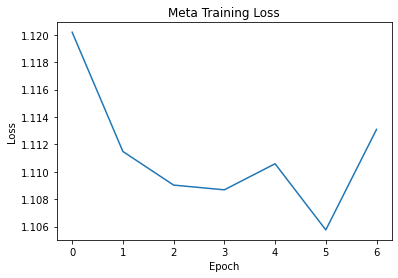

In [75]:



try:
  del reptile
except:
  pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reptile = Reptile(name = 'run1', model = MyPretrainedAlexNet(),dataloaders=meta_learning_loader, test_dataloader=None, tasks=100, n_shot=3, epochs=55, inner_lr=0.0001, meta_lr=0.0001, inner_steps=2, device = device)
reptile.train()
#reptile.test(TestFewShotLoader, pretrained_model=None)

In [69]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [76]:
!ls

meta_learning.ipynb
meta_tasks_symlink
{self.name}REPTILE_best_model.pth
{self.name}REPTILE_latest_model_interrupted_loss{meta_loss:.3f}.pth


In [78]:
!mv {self.name}REPTILE_best_model.pth REPTILE_best_model.pth

Loaded model ...
Performing inner loop ...
 Predicting on query set ...
Test loss is 1.0872137546539307
Accuracy on test task: 0.39444444444444443
Confusion Matrix on test task: 
[[72 50 57]
 [40 55 38]
 [21 12 15]]


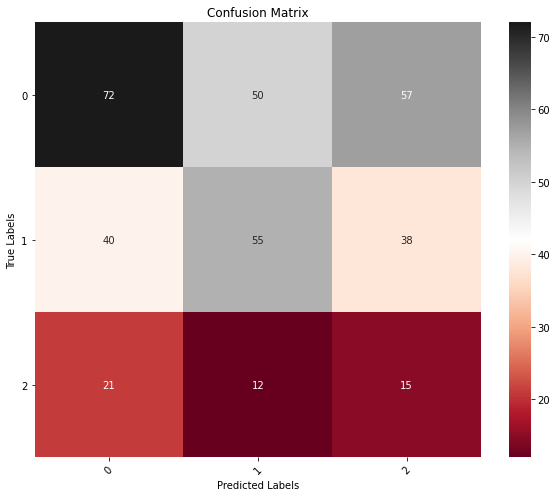

In [100]:
reptile = Reptile(name = 'run1', model = MyPretrainedAlexNet(),dataloaders=meta_learning_loader, test_dataloader=None, tasks=100, n_shot=3, epochs=55, inner_lr=0.0001, meta_lr=0.0001, inner_steps=2, device = device)

reptile.test(test_meta_learning_loader,pretrained_model ='REPTILE_best_model.pth')

/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model ...
Performing inner loop ...
 Predicting on query set ...
Test loss is 1.086916208267212
Accuracy on test task: 0.40555555555555556
Confusion Matrix on test task: 
[[71 57 51]
 [37 63 33]
 [19 17 12]]


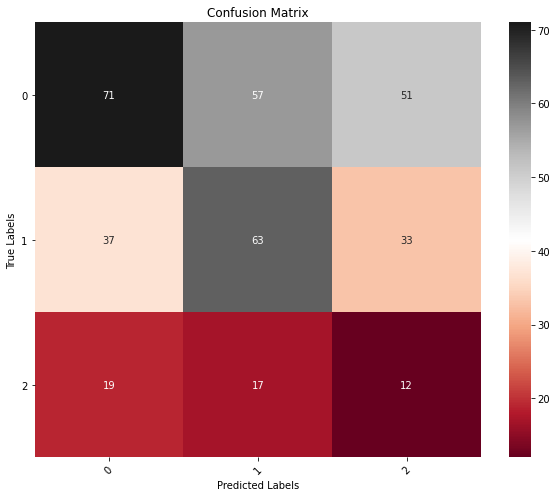

In [101]:
reptile = Reptile(name = 'run1', model = MyPretrainedAlexNet(),dataloaders=meta_learning_loader, test_dataloader=None, tasks=100, n_shot=3, epochs=55, inner_lr=0.0001, meta_lr=0.0001, inner_steps=5, device = device)

reptile.test(test_meta_learning_loader,pretrained_model ='REPTILE_best_model.pth')

/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model ...
Performing inner loop ...
 Predicting on query set ...
Test loss is 1.0016645193099976
Accuracy on test task: 0.4777777777777778
Confusion Matrix on test task: 
[[57 56 66]
 [29 87 17]
 [15  5 28]]


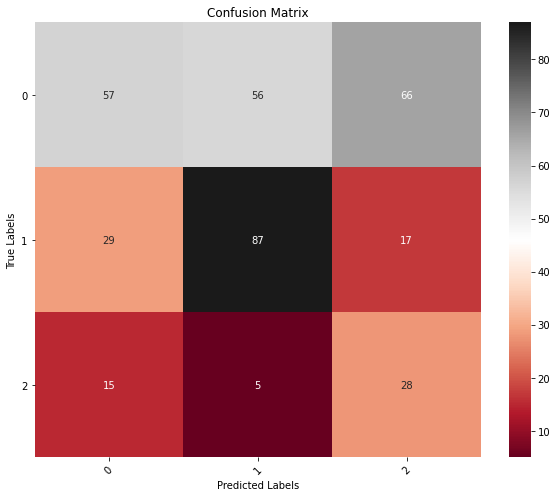

In [102]:
reptile = Reptile(name = 'run1', model = MyPretrainedAlexNet(),dataloaders=meta_learning_loader, test_dataloader=None, tasks=100, n_shot=3, epochs=55, inner_lr=0.0001, meta_lr=0.0001, inner_steps=50, device = device)

reptile.test(test_meta_learning_loader,pretrained_model ='REPTILE_best_model.pth')

/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model ...
Performing inner loop ...
 Predicting on query set ...
Test loss is 0.9262685179710388
Accuracy on test task: 0.5333333333333333
Confusion Matrix on test task: 
[[ 58  49  72]
 [ 16 103  14]
 [ 16   1  31]]


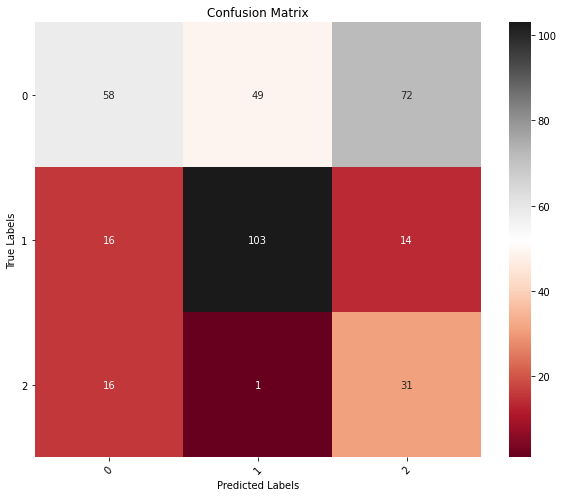

In [103]:
reptile = Reptile(name = 'run1', model = MyPretrainedAlexNet(),dataloaders=meta_learning_loader, test_dataloader=None, tasks=100, n_shot=3, epochs=55, inner_lr=0.0001, meta_lr=0.0001, inner_steps=100, device = device)

reptile.test(test_meta_learning_loader,pretrained_model ='REPTILE_best_model.pth')

In [98]:
test_meta_learning_loader[0]

(tensor([[[[-1.8782, -1.8782, -1.8782,  ..., -1.8953, -1.8953, -1.9124],
           [-1.8782, -1.8610, -1.8610,  ..., -1.8782, -1.8953, -1.8953],
           [-1.8782, -1.8610, -1.8782,  ..., -1.8782, -1.8953, -1.9124],
           ...,
           [-1.8268, -1.8097, -1.7925,  ..., -1.7925, -1.9124, -1.9638],
           [-1.8268, -1.8097, -1.8097,  ..., -1.8610, -1.9467, -1.9638],
           [-1.8439, -1.8268, -1.8268,  ..., -1.9295, -1.9809, -1.9809]],
 
          [[-1.7906, -1.7906, -1.7906,  ..., -1.8081, -1.8081, -1.8256],
           [-1.7906, -1.7731, -1.7731,  ..., -1.7906, -1.8081, -1.8081],
           [-1.7906, -1.7731, -1.7906,  ..., -1.7906, -1.8081, -1.8256],
           ...,
           [-1.7381, -1.7206, -1.7031,  ..., -1.7031, -1.8256, -1.8782],
           [-1.7381, -1.7206, -1.7206,  ..., -1.7731, -1.8606, -1.8782],
           [-1.7556, -1.7381, -1.7381,  ..., -1.8431, -1.8957, -1.8957]],
 
          [[-1.5604, -1.5604, -1.5604,  ..., -1.5779, -1.5779, -1.5953],
           [-

# REPTILE WITH SCHEDULER

In [13]:

class ReptileCloneScheduled:
    def __init__(self, name, model,dataloaders, test_dataloader=None, tasks=100, n_shot=3, epochs=50, inner_lr=0.01, meta_lr=0.001, inner_steps=10, device = 'cuda'):
        self.model = model
        self.device = device
        #print(self.model)
        #print(self.device)
        self.model = self.model.to(self.device)
        self.name = name
        self.tasks = tasks
        self.n_shot = n_shot
        self.epochs = epochs
        self.dataloaders = dataloaders
        #self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_outer)
        self.test_dataloader = test_dataloader
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.inner_steps = inner_steps
        self.inner_optimizer = optim.SGD(self.model.parameters(), lr=self.inner_lr)

    def inner_loop(self, task_support_set):

        X_train, y_train = task_support_set

        for t_epoch in range(self.inner_steps):
            self.model.train()
            preds = self.model(X_train)
            loss = nn.CrossEntropyLoss()(preds, y_train)
            self.inner_optimizer.zero_grad()
            loss.backward()
            self.inner_optimizer.step()

        return loss.item()


    def outer_loop(self, meta_lr_weight):

        meta_weights = {name: param.clone() for name, param in self.model.named_parameters() if 'running_mean' not in name and 'running_var' not in name}
        task_losses = 0.0
        update_directions = {name: 0 for name, _ in meta_weights.items()}
        
        for task in range(self.tasks):
            if task%1==0:
                print("\nWorking with task: {}".format(task + 1))
            support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = self.dataloaders[task]

            if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

            if len(query_set_X_batch.shape) == 5:
              query_set_X_batch = query_set_X_batch.squeeze(0)

            support_set_X_batch =support_set_X_batch.to(self.device)
            support_set_y_batch = support_set_y_batch.to(self.device)
            query_set_X_batch = query_set_X_batch.to(self.device)
            query_set_y_batch = query_set_y_batch.to(self.device)
            #print("shapes support set ", support_set_X_batch.shape, support_set_y_batch.shape, sep = ' : ')
            task_losses += self.inner_loop((support_set_X_batch, support_set_y_batch))

            for name, param in self.model.named_parameters():
              if 'running_mean' not in name and 'running_var' not in name:
                    update_directions[name] += (param.detach() - meta_weights[name])
        
        update_directions = {name: direction / self.tasks for name, direction in update_directions.items()}
        # Apply meta update
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if 'running_mean' not in name and 'running_var' not in name:
                    param += meta_lr_weight * self.meta_lr * update_directions[name]
                    
        
        self.model.train()
        self.model.load_state_dict(meta_weights)
        return task_losses/self.tasks



    def train(self):
        print('Start training...')
        best_loss = float('inf')
        best_model_weights = None
        meta_losses = []
        try:
          for epoch in tqdm(range(self.epochs)):
              meta_lr_weight = (1 - (epoch+1)/self.epochs)
              meta_loss = self.outer_loop(meta_lr_weight)
              meta_losses.append(meta_loss)
              if epoch % 1 == 0:
                  print('Epoch: %d, Meta Loss: ', epoch, meta_loss)
              if meta_loss < best_loss:
                  best_loss = meta_loss
                  best_model_weights = self.model.state_dict()

          torch.save(best_model_weights, '{self.name}_best_model.pth')
          print('Training finished.')
        except KeyboardInterrupt:
          torch.save(self.model.state_dict(), '{self.name}REPTILE_latest_model_interrupted_loss{meta_loss:.3f}.pth')
          if best_model_weights:
            torch.save(best_model_weights, '{self.name}REPTILE_best_model.pth')
        finally:
          plt.plot(meta_losses)
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title('Meta Training Loss')
          plt.show()

    def test(self, test_dataloader, pretrained_model = None):

      if pretrained_model:
        state_dict = torch.load(pretrained_model)
        self.model.load_state_dict(state_dict)


      fast_weights = deepcopy(self.model.state_dict())
      for task in range(len(test_dataloader)):

          support_set_X_batch, support_set_y_batch, query_set_X_batch, query_set_y_batch = test_dataloader[task]
          if len(query_set_X_batch.shape) == 5:
              support_set_X_batch = support_set_X_batch.squeeze(0)

          if len(query_set_X_batch.shape) == 5:
            query_set_X_batch = query_set_X_batch.squeeze(0)

          support_set_X_batch =support_set_X_batch.to(self.device)
          support_set_y_batch = support_set_y_batch.to(self.device)
          query_set_X_batch = query_set_X_batch.to(self.device)
          query_set_y_batch = query_set_y_batch.to(self.device)

          model_copy = self.inner_loop((support_set_X_batch, support_set_y_batch))

          model_copy.eval()
          with torch.no_grad():
              preds = model_copy(query_set_X_batch)
              _, preds = torch.max(preds, dim=1)
              accuracy = accuracy_score(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f"Accuracy on test task: {accuracy}")
              conf_mat = confusion_matrix(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())
              print(f'Confusion Matrix on test task: \n{conf_mat}')
              confusion_mat(query_set_y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy())

      self.model.train()  # Set the model back to training mode

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reptile = ReptileCloneScheduled(name = 'run1', model = MyPretrainedAlexNet(),dataloaders=meta_learning_loader, test_dataloader=None, tasks=100, n_shot=3, epochs=55, inner_lr=0.0001, meta_lr=0.01, inner_steps=2, device = device)
reptile.train()

/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/asugam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/55 [00:00<?, ?it/s]

Start training...

Working with task: 1

Working with task: 2

Working with task: 3

Working with task: 4

Working with task: 5

Working with task: 6

Working with task: 7

Working with task: 8

Working with task: 9

Working with task: 10

Working with task: 11

Working with task: 12

Working with task: 13

Working with task: 14

Working with task: 15

Working with task: 16

Working with task: 17

Working with task: 18

Working with task: 19

Working with task: 20

Working with task: 21

Working with task: 22

Working with task: 23

Working with task: 24

Working with task: 25

Working with task: 26

Working with task: 27

Working with task: 28

Working with task: 29

Working with task: 30

Working with task: 31

Working with task: 32

Working with task: 33

Working with task: 34

Working with task: 35

Working with task: 36

Working with task: 37

Working with task: 38

Working with task: 39

Working with task: 40

Working with task: 41

Working with task: 42
